In [55]:
import os
import numpy as np
import pandas as pd
import catboost
import scoring
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
import subprocess

import datetime

In [375]:
DATA_PATH = ""
SAVED_MODELS_PATH = ""
RANDSEED = None
# Constant if models are not trained
TRAIN = False
# Constant if required to save models
SAVE = True

# Data features
SIMPLE_FEATURE_COLUMNS = ['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
    'avg_cs[2]', 'avg_cs[3]', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]',
    'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]', 'MatchedHit_X[0]',
    'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]',
    'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]',
    'MatchedHit_Y[3]', 'MatchedHit_Z[0]', 'MatchedHit_Z[1]',
    'MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'MatchedHit_T[0]',
    'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]',
    'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
    'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
    'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
    'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
    'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]',
    'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]',
    'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]', 'Lextra_Y[2]',
    'Lextra_Y[3]', 'Mextra_DY2[0]', 'Mextra_DY2[1]', 'Mextra_DY2[2]',
    'Mextra_DY2[3]', 'Mextra_DX2[0]', 'Mextra_DX2[1]', 'Mextra_DX2[2]',
    'Mextra_DX2[3]', 'P', 'PT', ]


Code was written similar to the example from here: https://github.com/catboost/benchmarks/blob/master/shap_speed/speed_comparison.ipynb

In [359]:
def train_model(data, parameters={}, boosting=None, model=None):
    if boosting == 'Baseline':
        model = catboost.CatBoostClassifier(iterations=550, max_depth=8,
                                            learning_rate=parameters['learning_rate'],
                                            thread_count=16, verbose=False)
        model.fit(train.loc[:, SIMPLE_FEATURE_COLUMNS].values,
                  train.label.values,
                  sample_weight=train.weight.values)
    elif boosting == 'CatBoostClassifier':
        if model is None:
            params = {}
            if "learning_rate" in parameters:
                params["learning_rate"] = parameters["learning_rate"]
            if "max_depth" in parameters:
                params["max_depth"] = parameters["max_depth"]
            else:
                params["max_depth"] = 8
            if "tree_count" in parameters:
                params["iterations"] = parameters["tree_count"]
            else:
                params["iterations"] = 550
            model = catboost.CatBoostClassifier(thread_count=16, verbose=False, **params)
        model.fit(train.loc[:, SIMPLE_FEATURE_COLUMNS].values,
              train.label.values,
              sample_weight=train.weight.values)
    else:
        raise RuntimeError("Unknown boosting")
    return model

In [360]:
def evaluate(data, parameters, boosting, model):
    if boosting == 'Baseline':
        testing = subprocess.Popen(['cpp/catboost_eval',
                                    '-model', os.path.join(SAVED_MODELS_PATH, 'baseline.cbm'),
                                    '-output', os.path.join(DATA_PATH, 'model_pred.csv'),
                                    '-input', os.path.join(DATA_PATH, 'transformed_test_features.csv')],
                                    stdout=subprocess.PIPE)
        out, err = testing.communicate()
        time = float(out.decode("utf-8"))
        pred = pd.read_csv(os.path.join(DATA_PATH, 'model_pred.csv'))
        accuracy = scoring.rejection90(data.label.values, pred.prediction.values, data.weight.values)
    elif boosting == 'CatBoostClassifier':
        testing = subprocess.Popen(['cpp/catboost_eval',
                                    '-model', os.path.join(SAVED_MODELS_PATH, create_path(boosting, parameters)),
                                    '-output', os.path.join(DATA_PATH, 'model_pred.csv'),
                                    '-input', os.path.join(DATA_PATH, 'transformed_test_features.csv')],
                                    stdout=subprocess.PIPE)
        out, err = testing.communicate()
        time = float(out.decode("utf-8"))
        pred = pd.read_csv(os.path.join(DATA_PATH, 'model_pred.csv'))
        accuracy = scoring.rejection90(data.label.values, pred.prediction.values, data.weight.values)
    else:
        raise RuntimeError("Unknown boosting")
    return accuracy, time

In [361]:
def predict(data, model, boosting):
    if boosting == 'Baseline':
        return model.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values,
                             prediction_type="RawFormulaVal").astype(np.float32)
    if boosting == 'CatBoostClassifier':
        return model.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values,
                             prediction_type="RawFormulaVal").astype(np.float32)
    else:
        raise RuntimeError("Unknown boosting")

In [362]:
def find_opt_lr(train_data, test_data, parameters, boosting):
    model = None
    lr = [0.001, 0.3]
    while lr[1] - lr[0] > 0.001:
        mid = (lr[0] + lr[1]) / 2
        d = (lr[1] - lr[0]) * (2 / (np.sqrt(5) + 1) - 0.5)
        lr_1 = mid - d
        lr_2 = mid + d
        model_1 = train_model(train_data, {'learning_rate':lr_1, **parameters}, boosting)
        model_2 = train_model(train_data, {'learning_rate':lr_2, **parameters}, boosting)
        pred_1 = predict(test_data, model_1, boosting)
        pred_2 = predict(test_data, model_2, boosting)
        acc_1 = scoring.rejection90(test_data.label.values, pred_1, test_data.weight.values)
        acc_2 = scoring.rejection90(test_data.label.values, pred_2, test_data.weight.values)
        if acc_2 < acc_1:
            lr[1] = lr_2
            model = model_1
        else:
            lr[0] = lr_1
            model = model_2
    return model

In [363]:
def create_path(boosting, parameters):
    filename = [boosting]
    for key, value in sorted(parameters.items()):
        filename.append(str(key))
        filename.append(str(value))
    return '_'.join(filename).replace('.', '') + '.model'

In [364]:
def save_model(model, parameters, boosting):
    if boosting == 'CatBoostClassifier':
        model.save_model(os.path.join(SAVED_MODELS_PATH, create_path(boosting, parameters)))
    else:
        raise RuntimeError("Unknown boosting")

In [365]:
def load_model(parameters, boosting):
    if boosting == 'CatBoostClassifier':
        return catboost.CatBoostClassifier().load_model(os.path.join(SAVED_MODELS_PATH, create_path(boosting, parameters)))
    else:
        raise RuntimeError("Unknown boosting")

In [366]:
def change_threads_number(model, boosting, threads):
    if boosting == 'CatBoostClassifier':
        model.set_params(thread_count=threads)
    else:
        raise RuntimeError("Unknown boosting")

In [367]:
train = pd.read_csv(os.path.join(DATA_PATH, 'transformed_train_1.csv.gz'))
train_lr_data = pd.read_csv(os.path.join(DATA_PATH, 'lr_train.csv.gz'))
test = pd.read_csv(os.path.join(DATA_PATH, 'transformed_test.csv.gz'))

In [322]:
test.head()

,Unnamed: 0,ncl[0],ncl[1],ncl[2],ncl[3],avg_cs[0],avg_cs[1],avg_cs[2],avg_cs[3],MatchedHit_TYPE[0],...,Mextra_DX2[2],Mextra_DX2[3],P,PT,sWeight,particle_type,label,kinWeight,weight,sWeight_transformed
0,8140650,131,58,21,24,3.274809,2.327586,2.095238,1.958333,2,...,8719.71900,17679.87500,6442.218187,802.814526,0.640882,1,1,3.000000,1.263809,0.421270
1,614293,37,8,9,7,2.378378,1.750000,1.555556,1.000000,2,...,3955.96750,7649.25400,9429.777059,1114.872791,-0.416412,1,1,3.781851,1.751969,0.463257
2,7640885,24,11,3,9,1.833333,3.090909,1.333333,1.000000,2,...,268.90204,516.42566,32348.529154,2680.386518,1.185138,1,1,3.000000,2.608372,0.869457
3,260493,9,7,5,9,1.666667,1.142857,1.000000,1.000000,2,...,2671.15380,5186.96140,11616.517568,1292.761619,1.199231,1,1,2.805615,2.436372,0.868391
4,8470007,119,32,20,18,2.487395,3.218750,1.900000,1.222222,1,...,811.18964,1546.95670,20404.784421,1134.339739,-0.369020,0,0,31.125650,15.957847,0.512691


In [386]:
if TRAIN or not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'baseline.cbm')):
    baseline = find_opt_lr(train_lr_data, test, {}, 'Baseline')
    baseline.fit(train.loc[:, SIMPLE_FEATURE_COLUMNS].values,
                 train.label.values,
                 sample_weight=train.weight.values)
    if SAVE or not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'baseline.cbm')):
        baseline.save_model(os.path.join(SAVED_MODELS_PATH, 'baseline.cbm'))
else:
    baseline = catboost.CatBoostClassifier().load_model(os.path.join(SAVED_MODELS_PATH, 'baseline.cbm'))


baseline_accuracy, baseline_time = evaluate(test, {}, 'Baseline', baseline)

In [445]:
# Define parameters for models
parameters = {
    'tree_count': [*range(10, 61, 15)],
}
boosting_list = ['CatBoostClassifier',]
boosting_res = {}
for boosting in boosting_list:
    boosting_res[boosting] = []

Custom Grid Search with given parameters:

In [369]:
class GetParameters(object):
    def __init__(self, parameters, lengths=None):
        self.parameters = parameters
        if lengths is None:
            self.lengths = []
            for ls in parameters.values():
                self.lengths.append(len(ls) - 1)
        else:
            assert(len(lengths) == len(self.parameters))
            self.lengths = lengths
        self.is_generator = []
        for value in parameters.values():
            if hasattr(value, '__call__'):
                self.is_generator.append(True)
            else:
                self.is_generator.append(False)
        self.current = None
        
    def __iter__(self):
        return self
    
    def get_by_index(self, index):
        parameters = {}
        for it, parameter in enumerate(self.parameters.items()):
            if self.is_generator[it]:
                parameters[parameter[0]] = parameter[1]()
            else:
                parameters[parameter[0]] = parameter[1][self.current[it]]
        return parameters
    
    def __next__(self):
        if self.current is None:
            self.current = [0] * len(self.lengths)
            return self.get_by_index(self.current)
        else:
            for it in reversed(range(len(self.lengths))):
                if self.current[it] == self.lengths[it]:
                    self.current[it] = 0
                else:
                    self.current[it] += 1
                    return self.get_by_index(self.current)
            raise StopIteration

In [447]:
for current_parameters in GetParameters(parameters):
    for boosting in boosting_list:
        if TRAIN or not os.path.exists(os.path.join(SAVED_MODELS_PATH,
                                                    create_path(boosting, current_parameters))):
            model = find_opt_lr(train_lr_data, test, current_parameters, boosting)
            model = train_model(data=test, boosting=boosting, model=model)
            if SAVE or not os.path.exists(os.path.join(SAVED_MODELS_PATH,
                                                      create_path(boosting, current_parameters))):
                save_model(model, current_parameters, boosting)
        else:
            model = load_model(current_parameters, boosting)
        accuracy, time = evaluate(test, current_parameters, boosting, model)
        result = {**current_parameters}
        result['accuracy'] = accuracy
        result['time'] = time
        boosting_res[boosting].append(result)

In [371]:
plt_colours = ['b', 'g', 'r', 'y', 'k', 'c', 'm']

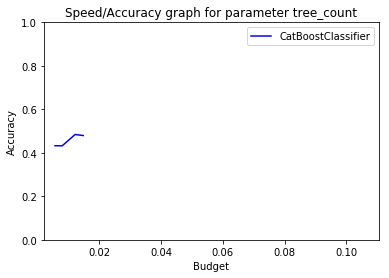

In [448]:
for parameter in parameters.keys():
    plt.figure()
    for it, boosting in enumerate(boosting_list):
        results = {}
        times = []
        accuracies = []
        for res in boosting_res[boosting]:
            if parameter in results:
                results[res[parameter]].append((res['time'], res['accuracy']))
            else:
                results[res[parameter]] = [(res['time'], res['accuracy'])]
        for val, item in results.items():
            # results[val] = np.mean(item, axis=0)
            results[val] = np.min(item, axis=0)
        for result in sorted(results.values(), key=lambda x: x[0]):
            times.append(result[0])
            accuracies.append(result[1])
        plt.plot(times, accuracies, plt_colours[it], label=boosting)
    plt.xlim([baseline_time * 0.02, baseline_time])
    plt.ylim([0, 1])
    plt.xlabel('Budget')
    plt.ylabel('Accuracy')
    plt.title('Speed/Accuracy graph for parameter {}'.format(parameter))
    plt.legend()
    plt.show()

[baseline_time * 0.02, baseline_time] = [0.00220996, 0.110498]


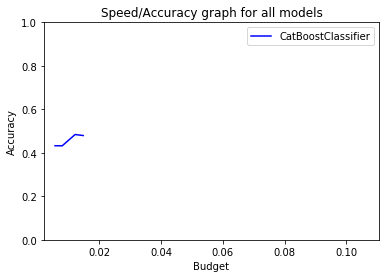

In [449]:
print("[baseline_time * 0.02, baseline_time] =", [baseline_time * 0.02, baseline_time])
for it, boosting in enumerate(boosting_list):
    results = {}
    times = []
    accuracies = []
    for res in boosting_res[boosting]:
        results[res['time']] = res['accuracy']
    for time in sorted(results.keys()):
        times.append(time)
        accuracies.append(results[time])
    plt.plot(times, accuracies, plt_colours[it], label=boosting)
plt.xlim([baseline_time * 0.02, baseline_time])
plt.ylim([0, 1])
plt.xlabel('Budget')
plt.ylabel('Accuracy')
plt.title('Speed/Accuracy graph for all models')
plt.legend()
plt.show()